In [1]:
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kstest

In [2]:
sys.path


['/Users/eitan_zimmerman/projects/FBA/notebooks/Historical Statistical Attributes',
 '/Users/eitan_zimmerman/.pyenv/versions/3.8.8/lib/python38.zip',
 '/Users/eitan_zimmerman/.pyenv/versions/3.8.8/lib/python3.8',
 '/Users/eitan_zimmerman/.pyenv/versions/3.8.8/lib/python3.8/lib-dynload',
 '',
 '/Users/eitan_zimmerman/.pyenv/versions/fba/lib/python3.8/site-packages']

In [76]:
data_path = '/Users/eitan_zimmerman/projects/FBA/data/epl_historical_data.csv'
df = pd.read_csv(data_path)

### Configs


In [77]:
pd.set_option('display.max_rows', None)
plt.rcParams['figure.figsize'] = (10,7)
plt.style.use('bmh')

## Exploring data set

In [78]:
df.head().T

0  \
PL_id                                                                    7467   
season                                                                2011/12   
match_week                                                                  1   
date                                                               08/13/2011   
kickoff                                                                 11:00   
referee                                                          Kevin Friend   
stadium                                                            Ewood Park   
city                                                                Blackburn   
attendance                                                              21996   
home_team                                                    Blackburn Rovers   
away_team                                             Wolverhampton Wanderers   
home_position                                                             0.0   
away_position                                                             0.0   
home_performance                                                          0.0   
away_performance                                                          0.0   
home_avg_scored                                                           0.0   
away_avg_scored                                                           0.0   
home_avg_conceded                                                         0.0   
away_avg_conceded                                                         0.0   
home_performance_last_five                                                NaN   
away_performance_last_five                                                NaN   
home_performance_as_home                                                  0.0   
away_performance_as_away                                                  0.0   
home_avg_scored_as_home                                                     0   
away_avg_scored_as_away                                                     0   
home_avg_conceded_as_home                                                   0   
away_avg_conceded_as_away                                                   0   
result                                                                   away   
home_score                                                                  1   
away_score                                                                  2   
home_ht_score                                                               1   
away_ht_score                                                               1   
home_goals                                               Mauro Formica 20' -    
away_goals                          Steven Fletcher 22' - Stephen Ward 47' -    
home_first_goal                                                            20   
away_first_goal                                                            22   
home_last_goal                                                             20   
away_last_goal                                                             47   
home_yellow_pl              David Dunn - Brett Emerton - Jason Roberts - S...   
away_yellow_pl                            Roger Johnson - Richard Stearman -    
home_red_pl                                                               NaN   
away_red_pl                                                               NaN   
home_posse                                                               52.0   
away_posse                                                               48.0   
home_shotsON                                                              2.0   
away_shotsON                                                              4.0   
home_shots                                                               17.0   
away_shots                                                               15.0   
home_passes                                                             330.0   
away_passes               

## Analysing Goals Distribution

In [79]:
cols_to_keep = ['season', 'match_week', 'date','kickoff', 'attendance', 
                'home_team', 'away_team', 'home_position', 'away_position',
                'home_score', 'away_score', 'home_goals', 'away_goals', 'result']

df = df[cols_to_keep]

In [80]:
df['total_goals'] = df['away_score'] + df['home_score']
df['date'] = pd.to_datetime(df['date'])

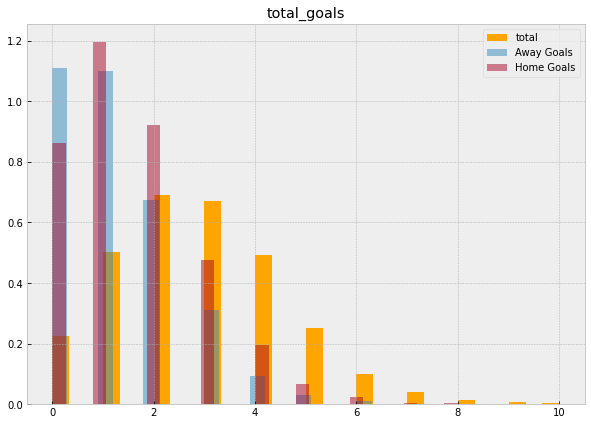

In [81]:
df.hist('total_goals', bins=30, density=True, label='total', color='orange')
plt.hist(df.away_score, histtype='stepfilled',alpha=0.5, bins=30,label='Away Goals', density=True)
plt.hist(df.home_score, histtype='stepfilled',alpha=0.5, bins=30,label='Home Goals', density=True)
plt.legend()
plt.show()

In [82]:
df[df['result'] != 'tie']['result'].value_counts(normalize=True)

home    0.600317
away    0.399683
Name: result, dtype: float64

### Comapring Goals to Poisson Distribtion

In [83]:
empirical_pois_lambda_total = df['total_goals'].mean()
kstest(df['total_goals'], 'poisson', args = (empirical_pois_lambda_total, 0))

KstestResult(statistic=0.24086867646738458, pvalue=2.2434566631846966e-170)

In [84]:
empirical_pois_lambda_home = df['home_score'].mean()
kstest(df['home_score'], 'poisson', args = (empirical_pois_lambda_home, 0))

KstestResult(statistic=0.3134618430876377, pvalue=5.393176039705045e-291)

In [85]:
empirical_pois_lambda_away = df['away_score'].mean()
kstest(df['away_score'], 'poisson', args = (empirical_pois_lambda_away, 0))

KstestResult(statistic=0.33064143961674913, pvalue=0.0)

### Checking for goals time distribution

In [86]:
df['home_goals'][8]

"Edin Dzeko 57' - Sergio Ag�ero 68'  90 ' - David Silva 71' - "

In [87]:
home_goals = df['home_goals'].str.extractall("(\d.)")[0].str.replace("'", "").reset_index()[0].astype(int)
away_goals = df['away_goals'].str.extractall("(\d.)")[0].str.replace("'", "").reset_index()[0].astype(int)
all_goals = pd.concat([home_goals, away_goals]) 

<AxesSubplot:>

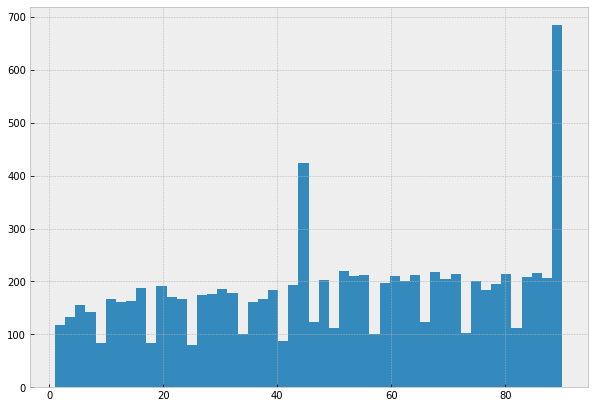

In [88]:
all_goals.hist(bins=50)

The reason why we see peaks in 90' and 45' is due to measuring error in our data.
Many football matches have "Extra Time" added in the end of each half, golas made in that extra time recieved the labels 45, 90 accordingly.

### Winning Goals 

We can see that goals are likely to happen uniformly~ with respect to their time. But when are the important goals are scored ?
We will define "Important Goal" to have an effect on the game state. That is a goal changing the game state to draw or win is considered to be more important goal. This is a simplistic way of anakysing importance as it doesn't take, what is ofently called Momentum, into consideration.<br/>

## Data processing

In [89]:
df.head()

season  match_week       date kickoff  attendance            home_team  \
0  2011/12           1 2011-08-13   11:00       21996     Blackburn Rovers   
1  2011/12           1 2011-08-13   11:00       25700               Fulham   
2  2011/12           1 2011-08-13   11:00       45018            Liverpool   
3  2011/12           1 2011-08-13   13:30       46894     Newcastle United   
4  2011/12           1 2011-08-13   11:00       15195  Queens Park Rangers   

                 away_team  home_position  away_position  home_score  \
0  Wolverhampton Wanderers            0.0            0.0           1   
1              Aston Villa            0.0            0.0           0   
2               Sunderland            0.0            0.0           1   
3                  Arsenal            0.0            0.0           0   
4         Bolton Wanderers            0.0            0.0           0   

   away_score            home_goals  \
0           2  Mauro Formica 20' -    
1           0                   NaN   
2           1    Luis Su�rez 12' -    
3           0                   NaN   
4           4                   NaN   

                                          away_goals result  total_goals  
0          Steven Fletcher 22' - Stephen Ward 47' -    away            3  
1                                                NaN    tie            0  
2                           Sebastian Larsson 57' -     tie            2  
3                                                NaN    tie            0  
4  Gary Cahill 45 ' - Danny Gabbidon 67' (og) - I...   away            4

In [90]:
goals_time_df = pd.concat(
[df['away_goals'].str.replace("'", "").str.extractall("(\d.)").astype(int).reset_index().set_index('level_0').drop('match', axis=1)\
.rename(columns={0:'away_goal'}),
 df['home_goals'].str.replace("'", "").str.extractall("(\d.)").astype(int).reset_index().set_index('level_0').drop('match', axis=1)\
.rename(columns={0:'home_goal'})]
).reset_index().sort_values('level_0').set_index('level_0')

games = df.join(goals_time_df)[['date','home_team', 'away_team', 
                                'home_score', 'away_score', 'result', 'away_goal', 'home_goal']]
games.head()

date         home_team                away_team  home_score  \
0 2011-08-13  Blackburn Rovers  Wolverhampton Wanderers           1   
0 2011-08-13  Blackburn Rovers  Wolverhampton Wanderers           1   
0 2011-08-13  Blackburn Rovers  Wolverhampton Wanderers           1   
1 2011-08-13            Fulham              Aston Villa           0   
2 2011-08-13         Liverpool               Sunderland           1   

   away_score result  away_goal  home_goal  
0           2   away       22.0        NaN  
0           2   away        NaN       20.0  
0           2   away       47.0        NaN  
1           0    tie        NaN        NaN  
2           1    tie       57.0        NaN

In [91]:
games = games.reset_index().rename(columns={'index':'game_id'})

Creating Initial State Rows

In [22]:
games.columns

Index(['game_id', 'date', 'home_team', 'away_team', 'home_score', 'away_score',
       'result', 'away_goal', 'home_goal', 'goals_per_minute',
       'current_state'],
      dtype='object')

In [92]:
games = games.dropna(subset=['away_goal', 'home_goal'], how='all')

In [101]:
games

game_id       date                 home_team                 away_team  \
0           0 2011-08-13          Blackburn Rovers   Wolverhampton Wanderers   
1           0 2011-08-13          Blackburn Rovers   Wolverhampton Wanderers   
2           0 2011-08-13          Blackburn Rovers   Wolverhampton Wanderers   
4           2 2011-08-13                 Liverpool                Sunderland   
5           2 2011-08-13                 Liverpool                Sunderland   
7           4 2011-08-13       Queens Park Rangers          Bolton Wanderers   
8           4 2011-08-13       Queens Park Rangers          Bolton Wanderers   
9           4 2011-08-13       Queens Park Rangers          Bolton Wanderers   
10          4 2011-08-13       Queens Park Rangers          Bolton Wanderers   
11          5 2011-08-13            Wigan Athletic              Norwich City   
12          5 2011-08-13            Wigan Athletic              Norwich City   
14          7 2011-08-14      West Bromwich Albion         Manchester United   
15          7 2011-08-14      West Bromwich Albion         Manchester United   
16          7 2011-08-14      West Bromwich Albion         Manchester United   
17          8 2011-08-15           Manchester City              Swansea City   
18          8 2011-08-15           Manchester City              Swansea City   
19          8 2011-08-15           Manchester City              Swansea City   
20          8 2011-08-15           Manchester City              Swansea City   
21          9 2011-08-20                   Arsenal                 Liverpool   
22          9 2011-08-20                   Arsenal                 Liverpool   
23         10 2011-08-20               Aston Villa          Blackburn Rovers   
24         10 2011-08-20               Aston Villa          Blackburn Rovers   
25         10 2011-08-20               Aston Villa          Blackburn Rovers   
26         10 2011-08-20               Aston Villa          Blackburn Rovers   
27         11 2011-08-20                   Chelsea      West Bromwich Albion   
28         11 2011-08-20                   Chelsea      West Bromwich Albion   
29         11 2011-08-20                   Chelsea      West Bromwich Albion   
30         12 2011-08-20                   Everton       Queens Park Rangers   
31         13 2011-08-20                Sunderland          Newcastle United   
33         15 2011-08-21          Bolton Wanderers           Manchester City   
34         15 2011-08-21          Bolton Wanderers           Manchester City   
35         15 2011-08-21          Bolton Wanderers           Manchester City   
36         15 2011-08-21          Bolton Wanderers           Manchester City   
37         15 2011-08-21          Bolton Wanderers           Manchester City   
38         16 2011-08-21              Norwich City                Stoke City   
39         16 2011-08-21              Norwich City                Stoke City   
40         17 2011-08-21   Wolverhampton Wanderers                    Fulham   
41         17 2011-08-21   Wolverhampton Wanderers                    Fulham   
42         18 2011-08-22         Manchester United         Tottenham Hotspur   
43         18 2011-08-22         Manchester United         Tottenham Hotspur   
44         18 2011-08-22         Manchester United         Tottenham Hotspur   
46         20 2011-08-27          Blackburn Rovers                   Everton   
47         21 2011-08-27                   Chelsea              Norwich City   
48         21 2011-08-27                   Chelsea              Norwich City   
49         21 2011-08-27                   Chelsea              Norwich City   
50         21 2011-08-27                   Chelsea              Norwich City   
51         22 2011-08-27                 Liverpool          Bolton Wanderers   
52         22 2011-08-27                 Liverpool          Bolton Wanderers   
53         22 2011-08-27                 Liverpool          Bolton Wanderers   
54    

In [104]:
games['goals_minutes'] = games.apply(lambda r: r['away_goal'] if pd.notna(r['away_goal']) else r['home_goal'], axis=1)
games = games.sort_values(['game_id', 'goals_minutes'])

In [105]:
games.head()

game_id       date         home_team                away_team  home_score  \
1        0 2011-08-13  Blackburn Rovers  Wolverhampton Wanderers           1   
0        0 2011-08-13  Blackburn Rovers  Wolverhampton Wanderers           1   
2        0 2011-08-13  Blackburn Rovers  Wolverhampton Wanderers           1   
5        2 2011-08-13         Liverpool               Sunderland           1   
4        2 2011-08-13         Liverpool               Sunderland           1   

   away_score result  away_goal  home_goal  goals_minutes  
1           2   away        NaN       20.0           20.0  
0           2   away       22.0        NaN           22.0  
2           2   away       47.0        NaN           47.0  
5           1    tie        NaN       12.0           12.0  
4           1    tie       57.0        NaN           57.0

In [112]:
games['home_score_ind'] = games['home_goal'].notna().astype(int).fillna(0)
games['away_score_ind'] = games['away_goal'].notna().astype(int).fillna(0)

games['cum_score_home'] = games.groupby('game_id')['home_score_ind'].cumsum()
games['cum_score_away'] = games.groupby('game_id')['away_score_ind'].cumsum()

games.head()

game_id       date         home_team                away_team  home_score  \
1        0 2011-08-13  Blackburn Rovers  Wolverhampton Wanderers           1   
0        0 2011-08-13  Blackburn Rovers  Wolverhampton Wanderers           1   
2        0 2011-08-13  Blackburn Rovers  Wolverhampton Wanderers           1   
5        2 2011-08-13         Liverpool               Sunderland           1   
4        2 2011-08-13         Liverpool               Sunderland           1   

   away_score result  away_goal  home_goal  goals_minutes  home_score_ind  \
1           2   away        NaN       20.0           20.0               1   
0           2   away       22.0        NaN           22.0               0   
2           2   away       47.0        NaN           47.0               0   
5           1    tie        NaN       12.0           12.0               1   
4           1    tie       57.0        NaN           57.0               0   

   away_score_ind  cum_score_home  cum_score_away  
1               0               1               0  
0               1               1               1  
2               1               1               2  
5               0               1               0  
4               1               1               1

In [113]:
def calc_game_state(row):
    home, away = row['cum_score_home'], row['cum_score_away']
    if home > away:
        return 'HOME'
    elif home < away:
        return 'AWAY'
    else:
        return 'TIE'
games['game_state'] = games.apply(calc_game_state, axis=1)
games['game_changer'] = games.groupby('game_id')['game_state'].shift(1) != games['game_state']
games.head()

game_id       date         home_team                away_team  home_score  \
1        0 2011-08-13  Blackburn Rovers  Wolverhampton Wanderers           1   
0        0 2011-08-13  Blackburn Rovers  Wolverhampton Wanderers           1   
2        0 2011-08-13  Blackburn Rovers  Wolverhampton Wanderers           1   
5        2 2011-08-13         Liverpool               Sunderland           1   
4        2 2011-08-13         Liverpool               Sunderland           1   

   away_score result  away_goal  home_goal  goals_minutes  home_score_ind  \
1           2   away        NaN       20.0           20.0               1   
0           2   away       22.0        NaN           22.0               0   
2           2   away       47.0        NaN           47.0               0   
5           1    tie        NaN       12.0           12.0               1   
4           1    tie       57.0        NaN           57.0               0   

   away_score_ind  cum_score_home  cum_score_away game_state  game_changer  
1               0               1               0       HOME          True  
0               1               1               1        TIE          True  
2               1               1               2       AWAY          True  
5               0               1               0       HOME          True  
4               1               1               1        TIE          True

<AxesSubplot:xlabel='goals_minutes', ylabel='Probability'>

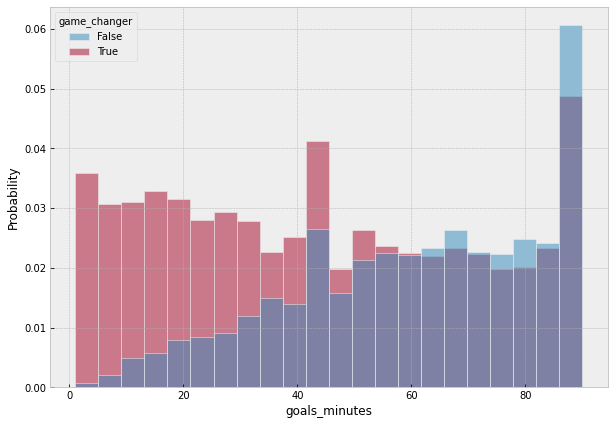

In [123]:
sns.histplot(data=games, x='goals_minutes', hue='game_changer', stat='probability')

<AxesSubplot:xlabel='goals_minutes', ylabel='Count'>

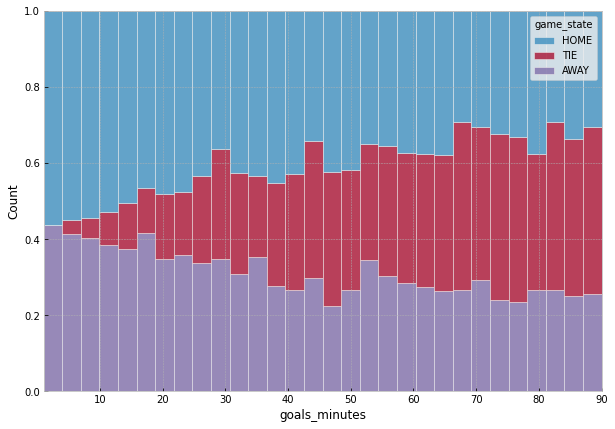

In [167]:
sns.histplot(data=games[games['game_changer'] == True], x='goals_minutes',
             hue='game_state', stat='count', bins=30, multiple='fill')

<AxesSubplot:xlabel='goals_minutes', ylabel='Count'>

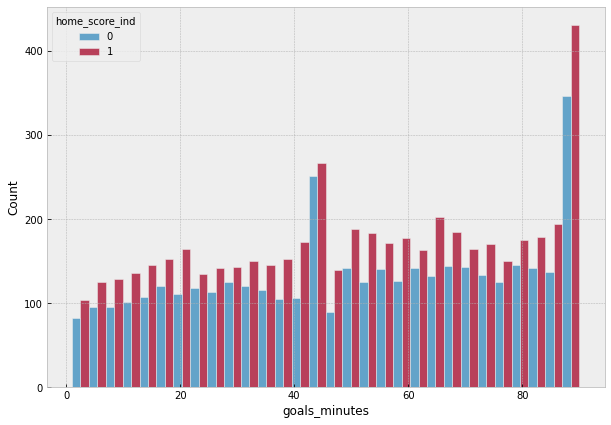

In [173]:
sns.histplot(data=games, x='goals_minutes',
             hue='home_score_ind', stat='count', bins=30, multiple='dodge')

In [125]:
games['time_left_to_respond'] = 90 - games['goals_minutes']


In [131]:
games['game_changer'].value_counts()

True     5542
False    3576
Name: game_changer, dtype: int64

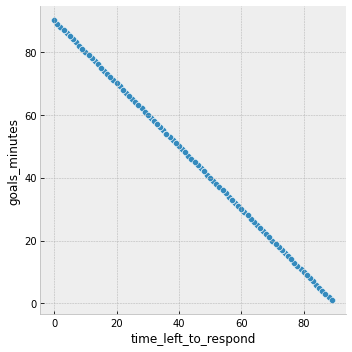

In [132]:
sns.relplot(data=games, x='time_left_to_respond', y='')